# Fetching crypto and tweets data.

In [1]:
from sklearn.preprocessing import OrdinalEncoder
from TweetScraper import TweetScraper
from CryptoApi import CryptoApi
import pandas as pd
import numpy as np
import re


# scrp = TweetScraper(start='2023-05-04', end='2023-05-14', maxEmptyPages=2, max_workers=8)
# new_tweets = scrp.parallel_download_tweets()
# new_twt = pd.DataFrame(new_tweets)


# with open('crypto_token.txt','r') as f:
#     token = f.readline()
    
# crypto = CryptoApi(token)
# crypto.get_data('btc','usd','day',period_count=90)

# Analysis of tweets

In [2]:
# new_tweets_df = TweetScraper().fetch_data('2023-04-10','2023-06-09', frequency='d')
# cleaned_df = TweetCleaner().transform(new_tweets_df)
# nlp_model = LDA().fit(cleaned_df)
# cleaned_df = extract_topics(nlp_model.topics)

# new_btc_df = CryptoApi().fetch_data()
# cleaned_btc = CryptoCleaner().transform(new_btc_df)
# xgb_model = XGBoost().fit(cleaned_btc)

In [3]:
from DataPreparation.CryptoPreprocessor import CryptoPreprocessor
from DataPreparation.TweetPreprocessor import TweetPreprocessor
from DataPreparation.TextVectorizer import TextVectorizer
from gensim.test.utils import datapath
from gensim.models import LdaMulticore


tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
twt_prep = TweetPreprocessor(tweets_df)
mod_tweets_df = twt_prep.transform()

text2vec = TextVectorizer()
preprocessing_pipeline = text2vec.make_pipeline()
id2word, corpus = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())

In [65]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs


def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

def optimize_bayes(func, pbounds=None, verbose=2):
    if pbounds==None:
        pbounds = {'x': (2, 12), 'y': (-15, 15)}
        
    optimizer = BayesianOptimization(
        f=func,
        pbounds=pbounds,
        verbose=verbose, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
    # optimizer.maximize(init_points=2,n_iter=3)
            
    # for i, res in enumerate(optimizer.res):
    #     print(f"Iteration {i}:\n{res}")
                
    # optimizer.set_bounds(new_bounds={"x": (-2, 3)})
    optimizer.maximize(init_points=0, n_iter=15)
            
    # optimizer.probe(params={"x": 0.5, "y": 0.7}, lazy=True)
    
    logger = JSONLogger(path="./logs.log")
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
    optimizer.maximize(init_points=2,n_iter=3)

    
optimize_bayes(func=black_box_function, verbose=2)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -68.54    | 6.17      | 6.61      |
| 2         | -32.87    | 3.088     | -3.934    |
| 3         | -119.6    | 10.3      | 4.804     |
| 4         | -19.41    | 3.493     | 3.864     |
| 5         | -52.89    | 2.861     | 7.761     |
| 6         | -158.9    | 5.956     | -10.16    |
| 7         | -3.768    | 2.0       | 0.1238    |
| 8         | -339.0    | 12.0      | 15.0      |
| 9         | -37.78    | 5.997     | -0.6789   |
| 10        | -4.84     | 2.0       | 2.357     |
| 11        | -6.053    | 2.654     | 1.102     |
| 12        | -3.02     | 2.0       | 1.142     |
| 13        | -3.015    | 2.0       | 0.8758    |
| 14        | -3.059    | 2.0       | 1.243     |
| 15        | -3.013    | 2.0       | 0.8849    |
| 16        | -3.005    | 2.0       | 0.9285    |
|   iter    |  target   |     x     |     y     |
-------------------------------------------------


In [54]:
new_optimizer = BayesianOptimization(f=black_box_function,
                                     pbounds={"x": (-2, 2), "y": (-2, 2)},
                                     verbose=2,
                                     random_state=7)
print(len(new_optimizer.space))

0


In [57]:
load_logs(new_optimizer, logs=["./logs.log.json"])
print("New optimizer is now aware of {} points.".format(len(new_optimizer.space)))

New optimizer is now aware of 6 points.


In [58]:
new_optimizer.maximize(
    init_points=0,
    n_iter=10,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -4.0      | -2.0      | 2.0       |
| 2         | -7.104    | 2.0       | -1.026    |
| 3         | -3.271    | 2.0       | 1.521     |
| 4         | -3.545    | -2.0      | 0.2615    |
| 5         | 0.6526    | -0.5868   | 1.055     |
| 6         | 0.9835    | -0.03497  | 0.8763    |
| 7         | -0.2424   | -0.4923   | 2.0       |
| 8         | 0.7287    | 0.4862    | 1.187     |
| 9         | 0.9811    | 0.1185    | 1.07      |
| 10        | 0.9562    | -0.1716   | 1.12      |


In [4]:
temp_file = datapath(r"D:\Projects\ElonMuskCrypto\Models\NLPmodels\lda")
lda_model = LdaMulticore.load(temp_file)

btc_df = pd.read_csv('Data/btc_data.csv', index_col=0)
crypto_prep = CryptoPreprocessor()
topics_btc = crypto_prep.transform(lda_model, mod_tweets_df, btc_df)


To drop:
retweetedTweet     0.000000
coordinates        0.000000
place              0.000000
hashtags           0.002238
card               0.041658
viewCount          0.119786
quoted_text        0.030138
quoted_username    0.030138
dtype: float64

To drop:
conversionSymbol    0.0
dtype: float64


Text(0.5, 1.0, 'open by month')

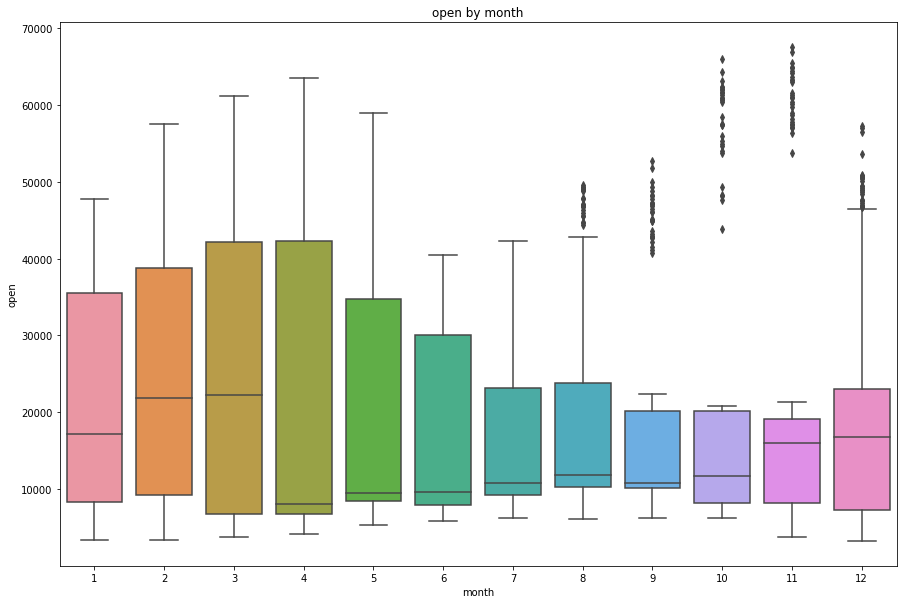

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=topics_btc, x='month',y='open')
ax.set_title('open by month')

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit


X = topics_btc.drop(['close'], axis=1)
y = topics_btc['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=25)

[0]	validation_0-rmse:18674.01221	validation_1-rmse:19290.63690
[25]	validation_0-rmse:177.42172	validation_1-rmse:684.21713
[50]	validation_0-rmse:79.27587	validation_1-rmse:685.61612
[66]	validation_0-rmse:45.86793	validation_1-rmse:690.71232


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

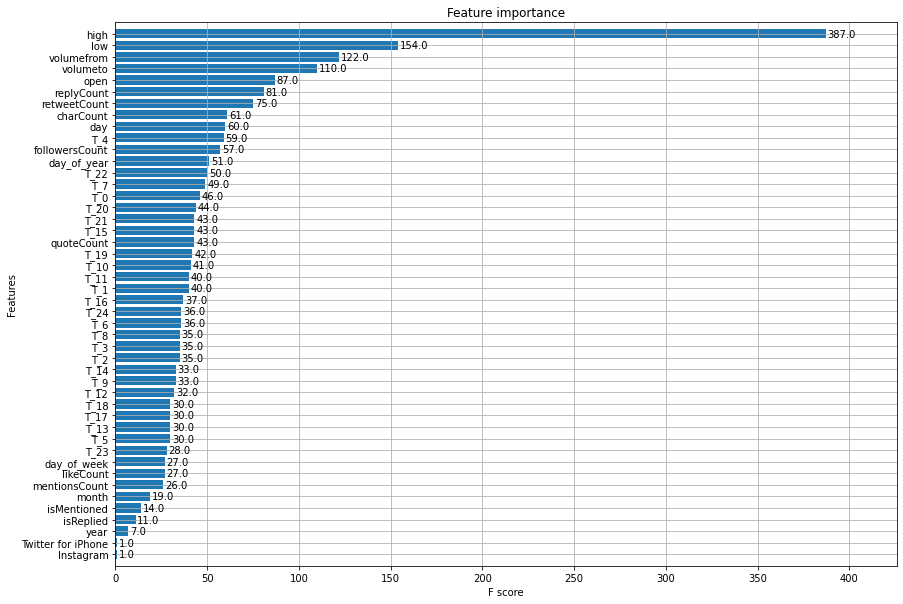

In [7]:
ax = xgb.plot_importance(reg, height=0.8)
fig = ax.figure
fig.set_size_inches(14, 10)

In [8]:
test = X_test.copy()

test['preds'] = reg.predict(X_test)
df = pd.DataFrame(y).merge(test[['preds']], how='inner', left_index=True, right_index=True)
df['absolute_error'] = abs(df['close'] - df['preds'])
df['percentage_error'] = abs(df['close'] - df['preds'])/df['close']*100
df

,close,preds,absolute_error,percentage_error
date,,,,
2017-12-07,16850.31,15609.073242,1241.236758,7.366255
2017-12-08,16047.61,15822.155273,225.454727,1.404912
2017-12-20,16461.97,16647.812500,185.842500,1.128920
2017-12-23,14396.46,15593.302734,1196.842734,8.313452
2018-01-05,16954.78,15720.531250,1234.248750,7.279651
...,...,...,...,...
2023-03-06,22410.34,22294.183594,116.156406,0.518316
2023-03-07,22200.87,21973.693359,227.176641,1.023278
2023-03-10,20207.71,20358.697266,150.987266,0.747177


In [9]:
# X = topics_btc.drop(['close'], axis=1)
# y = topics_btc['close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest  = xgb.DMatrix(X_test, label=y_test)

# param = {'max_depth': 12, 'objective': 'reg:squarederror'}
# param['nthread'] = 8
# param['eval_metric'] = 'mape'
# #param['eval_metric'] = 'auc'
# evallist = [(dtrain, 'train'), (dtest, 'test')]

# num_round = 30
# bst = xgb.train(param, dtrain, num_round, evals=evallist)

In [10]:
# ax = xgb.plot_importance(bst, height=0.8)
# fig = ax.figure
# fig.set_size_inches(14, 10)

In [11]:
#TODO: make tracker for features that were dropped due to high sparsity in case of leaving threshold of 50% sparsity
# for future model upgrading and adding new features.

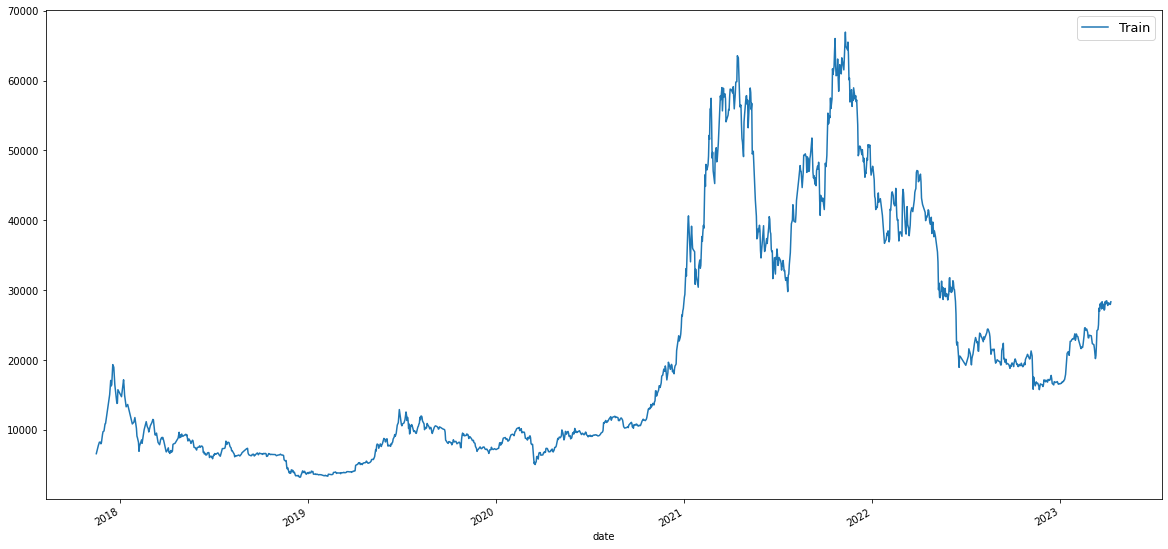

In [12]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20,10))
X_train['open'].plot(ax=ax, label='Train set')
# X_test['open'].plot(ax=ax, label='Test set')
# ax.axvline('', color='black', ls='--')
ax.legend(['Train','Test'], fontsize=13)
plt.show()